# On-policy Bandit Algorithms
*This notebook is complementary material for the [Practical Bandits - An Industry Perspective](https://sites.google.com/view/practical-bandits-tutorial) tutorial at The Web Conference 2023 - Austin, Texas. Tutorial slides are available [the tutorial website](https://sites.google.com/view/practical-bandits-tutorial).*

## About this notebook
Understanding how to apply counterfactual learning approaches in practise can be overwhelming.

In this notebook, we implement a few basic on-policy Bandit Algorithms to supplement the methods described in the tutorial slides.

### What you will learn by going through this notebook
1. How basic algorithms such as UCB and Explore-and-commit can be implemented.
1. How to use [Open Bandit Pipeline](https://github.com/st-tech/zr-obp) to create some basic simulations for benchmarking on-policy bandit algorithms.

In [1]:
!pip install obp

In [2]:
import numpy as np

from obp.dataset import logistic_sparse_reward_function
from obp.policy import Random, EpsilonGreedy

from obp.simulator.simulator import BanditEnvironmentSimulator, BanditPolicySimulator

## Implementing on-policy algorithms

### Explore-the-Commit

In [3]:
from obp.policy import BaseContextFreePolicy
from dataclasses import dataclass

@dataclass
class ExploreThenCommit(BaseContextFreePolicy):
    explore_rounds: float = None

    def __post_init__(self) -> None:
        """Initialize class."""
        super().__post_init__()
        self.policy_name = f"ETC-{self.explore_rounds}-rounds"
        self.mean_rewards = np.ones(self.n_actions)
        self.reward = np.ones(self.n_actions)
        self.arm_pulls = np.ones(self.n_actions)
        self.total_rounds = 0

    def select_action(self) -> np.ndarray:
        if self.total_rounds < self.explore_rounds:
            return [self.total_rounds % self.n_actions]
        else:
            return [np.argmax(self.mean_rewards)]

    def update_params(self, action: int, reward: float) -> None:
        self.reward[action] += reward
        self.arm_pulls[action] += 1
        self.total_rounds += 1

        self.mean_rewards[action] = self.reward[action]/self.arm_pulls[action]


### Upper Confidence Bound (UCB)

In [4]:
@dataclass
class UpperConfidenceBound(BaseContextFreePolicy):
    delta: float = None
    policy_name: str = "UCB"

    def __post_init__(self) -> None:
        """Initialize class."""
        super().__post_init__()
        self.upper_confidence_bounds = np.ones(self.n_actions) * np.inf
        self.reward = np.ones(self.n_actions)
        self.arm_pulls = np.ones(self.n_actions)

    def select_action(self) -> np.ndarray:
        return [np.argmax(self.upper_confidence_bounds)]

    def update_params(self, action: int, reward: float) -> None:
        self.reward[action] += reward
        self.arm_pulls[action] += 1

        mean_reward = self.reward[action]/self.arm_pulls[action]
        self.upper_confidence_bounds[action] = mean_reward + np.sqrt(2 * np.log(1/self.delta) / self.arm_pulls[action])



### Simulation setup


In [5]:
n_actions = 10
dim_context = 1
n_rounds = 50000

# Create random uniform rewards for each arm, except for one that is the optimal arm
true_mean_rewards = np.random.uniform(0, .1, size=(n_actions))
true_mean_rewards[1] = .12

def bernoulli_reward(context, **kwargs):
    n_rounds = context.shape[0]
    return np.tile(true_mean_rewards, (n_rounds, 1))

env = BanditEnvironmentSimulator(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_type="binary", # "binary" or "continuous"
    reward_function=bernoulli_reward,
    random_state=12345,
)



### Simulating the on-policy algorithms


In [59]:
bandit_policies = [
    (Random, {"n_actions": n_actions, "epsilon": 1.0, "random_state": 12345}),
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.20, "random_state": 12345}),
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.05, "random_state": 12345}),
    (ExploreThenCommit, {"n_actions": n_actions, "explore_rounds": 1000, "random_state": 12345}),
    (ExploreThenCommit, {"n_actions": n_actions, "explore_rounds": 100, "random_state": 12345}),
    (UpperConfidenceBound, {"n_actions": n_actions, "delta": .9, "random_state": 12345}),
]

training_bandit_batch = env.next_bandit_round_batch(n_rounds=n_rounds)

cumulative_rewards = {}
for policy_class, args in bandit_policies:
    policy = policy_class(**args)

    training_simulator = BanditPolicySimulator(policy=policy)

    training_simulator.steps(batch_bandit_rounds=training_bandit_batch)
    cumulative_rewards[policy.policy_name] = np.cumsum(training_simulator.obtained_rewards)


BanditRounds(n_rounds=50000, n_actions=10, context=array([[-2.14228862],
       [-1.20597357],
       [-0.13658995],
       ...,
       [-1.45204592],
       [-0.53694444],
       [-0.51482475]]), action_context=array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), rewards=array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]]), expected_rewards=array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
 

100%|██████████| 50000/50000 [00:01<00:00, 44669.58it/s]


### Results
The plot below demonstrates the cumulative reward for each of the on-policy models at the first and last 1000 rounds, which give us the follow observations.

*Epsilon greedy with a well-picked $\epsilon$ (0.05 in the example) does great on the short term, but is suboptimal in the long term*. As mentioned in the tutorial slides, with a good epsilon we do end up finding the optimal arm. However, the continous exploration is sacrifising performing in the long-term.

*ETC is among the top performers*, which is not unsurprising giving our setup. With just 1000 rounds of exploration, ETC is able to identify the optimal arm. However, when ETC is exploring insufficiently (100 rounds) is among the lowest performers. In reality it is almost impossible picking a good number of explore rounds.

*UCB performs about the same as the optimally picked ETC*. This shows the power of UCB, as the selection of exploration rate of UCB is automatically adjusted based on uncertainty.

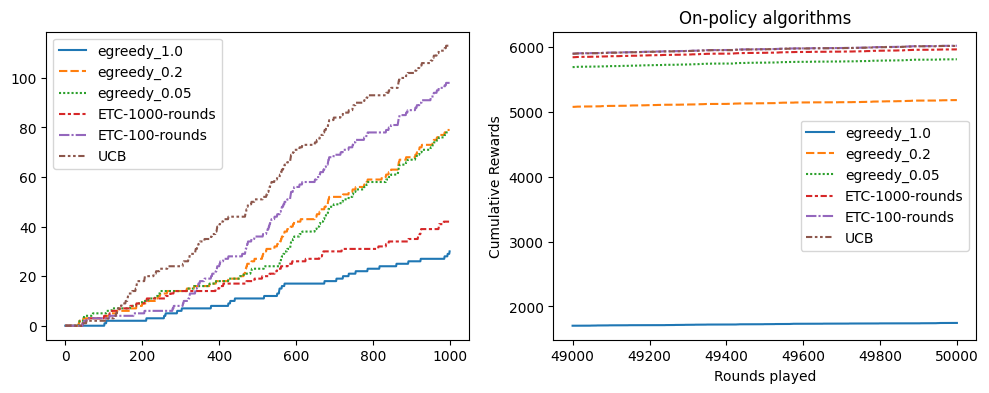

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(cumulative_rewards)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

sns.lineplot(data=df.iloc[:1000], ax=axes[0])
sns.lineplot(data=df[-1000:], ax=axes[1])


plt.xlabel('Rounds played')
plt.ylabel('Cumulative Rewards')
plt.title('On-policy algorithms')

plt.show()

## Cambiando el Optimal Arm

Modificamos la funcion de reward, para que con un random alternemos el brazo óptimo

In [99]:
n_actions = 10
dim_context = 1
n_rounds = 20000

def bernoulli_reward(context, **kwargs):
    # Create random uniform rewards for each arm, except for one that is the optimal arm
    true_mean_rewards = np.random.uniform(0, .1, size=(n_actions))
    optimal_arm = np.random.choice(n_actions)
    true_mean_rewards[optimal_arm] = 0.12
    print("optimal arm at random: ", optimal_arm)
    n_rounds = context.shape[0]
    return np.tile(true_mean_rewards, (n_rounds, 1))

env = BanditEnvironmentSimulator(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_type="binary", # "binary" or "continuous"
    reward_function=bernoulli_reward,
    random_state=12345,
)

El entrenamiento se lleva a cabo de forma iterativa, cada cierta cantidad de rondas, cambiamos al azar el brazo óptimo y manteniendo el historial sobre los rewards acumulados de cada bandit.

In [100]:
np.random.seed(12345)

n_arm_switches = 5
arm_switch_length = 10000
cumulative_rewards = {}

for _ in range(n_arm_switches):
    training_bandit_batch = env.next_bandit_round_batch(n_rounds=arm_switch_length)

    for policy_class, args in bandit_policies:
        policy = policy_class(**args)

        training_simulator = BanditPolicySimulator(policy=policy)

        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)
        cumulative_rewards[policy.policy_name] = np.cumsum(training_simulator.obtained_rewards)

    print("cumulative rewards after batch: ", cumulative_rewards)

optimal arm at random:  0


100%|██████████| 10000/10000 [00:00<00:00, 13143.42it/s]


cumulative rewards after batch:  {'egreedy_1.0': array([  0,   0,   0, ..., 609, 609, 609]), 'egreedy_0.2': array([   0,    0,    0, ..., 1129, 1130, 1130]), 'egreedy_0.05': array([   0,    0,    0, ..., 1206, 1207, 1207]), 'ETC-1000-rounds': array([   0,    0,    0, ..., 1151, 1152, 1152]), 'ETC-100-rounds': array([   0,    0,    0, ..., 1232, 1233, 1233]), 'UCB': array([   0,    0,    0, ..., 1148, 1149, 1149])}
optimal arm at random:  4


100%|██████████| 10000/10000 [00:00<00:00, 41800.04it/s]


cumulative rewards after batch:  {'egreedy_1.0': array([  1,   1,   1, ..., 577, 577, 577]), 'egreedy_0.2': array([   1,    1,    1, ..., 1039, 1039, 1039]), 'egreedy_0.05': array([   1,    1,    1, ..., 1162, 1162, 1162]), 'ETC-1000-rounds': array([   0,    0,    0, ..., 1130, 1130, 1130]), 'ETC-100-rounds': array([   0,    0,    0, ..., 1168, 1168, 1168]), 'UCB': array([   0,    0,    0, ..., 1130, 1130, 1130])}
optimal arm at random:  5


100%|██████████| 10000/10000 [00:00<00:00, 39990.47it/s]


cumulative rewards after batch:  {'egreedy_1.0': array([  0,   1,   1, ..., 554, 554, 554]), 'egreedy_0.2': array([   0,    1,    1, ..., 1071, 1071, 1071]), 'egreedy_0.05': array([  0,   1,   1, ..., 845, 845, 845]), 'ETC-1000-rounds': array([   0,    0,    0, ..., 1136, 1136, 1136]), 'ETC-100-rounds': array([   0,    0,    0, ..., 1182, 1182, 1182]), 'UCB': array([   0,    0,    0, ..., 1155, 1155, 1155])}
optimal arm at random:  2


100%|██████████| 10000/10000 [00:00<00:00, 47501.96it/s]


cumulative rewards after batch:  {'egreedy_1.0': array([  0,   0,   0, ..., 612, 612, 612]), 'egreedy_0.2': array([   0,    0,    0, ..., 1075, 1075, 1075]), 'egreedy_0.05': array([  0,   0,   0, ..., 943, 943, 943]), 'ETC-1000-rounds': array([   0,    0,    0, ..., 1133, 1133, 1133]), 'ETC-100-rounds': array([   0,    0,    0, ..., 1182, 1182, 1182]), 'UCB': array([  0,   0,   0, ..., 882, 882, 882])}
optimal arm at random:  3


100%|██████████| 10000/10000 [00:00<00:00, 47298.93it/s]

cumulative rewards after batch:  {'egreedy_1.0': array([  0,   0,   0, ..., 676, 676, 676]), 'egreedy_0.2': array([   0,    0,    0, ..., 1130, 1130, 1130]), 'egreedy_0.05': array([   0,    0,    0, ..., 1240, 1240, 1240]), 'ETC-1000-rounds': array([   0,    0,    0, ..., 1222, 1222, 1222]), 'ETC-100-rounds': array([  0,   0,   0, ..., 888, 888, 888]), 'UCB': array([   0,    0,    0, ..., 1020, 1020, 1020])}


Text(0.5, 1.0, 'On-policy algorithms')

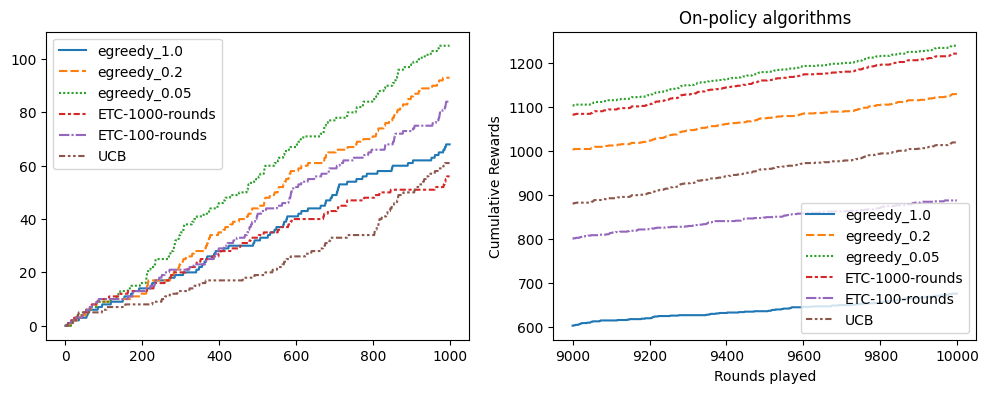

In [101]:
df = pd.DataFrame(cumulative_rewards)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

sns.lineplot(data=df.iloc[:1000], ax=axes[0])
sns.lineplot(data=df[-1000:], ax=axes[1])


plt.xlabel('Rounds played')
plt.ylabel('Cumulative Rewards')
plt.title('On-policy algorithms')

Notamos que UCB pasa de ser el mejor algoritmo en el paradigma donde el brazo no cambia, a ser el peor en el corto plazo e incluso peor que random, esta es la motivación del estudio y algoritmos que vamos a proponer

# Basura!

cosas que no funcionaron ...

### Setup de la simulación

Usamos 'reward_function', para definir rewards perosnalizados, en este caso, queremos cambiar abruptamente el brazo óptimo, así estudiar cómo se ajustan los métodos anteriores.

In [57]:
###### Primer paso: crear una simulación donde el brazo óptimo se alterna ######

# Define the custom reward function with switching optimal arm logic
switch_rounds = 10000

def custom_reward_with_switch(context, current_round, switch_rounds=50, n_actions=10):
    n_rounds = context.shape[0]

    # Calculate the optimal arm based on the current round
    optimal_arm = (current_round // switch_rounds) % n_actions

    # Set up true mean rewards with a high reward for the optimal arm
    true_mean_rewards = np.zeros(n_actions)
    true_mean_rewards[optimal_arm] = 0.9  # High probability for the optimal arm
    true_mean_rewards += 0.05 * np.random.rand(n_actions)  # Baseline for other arms

    # Adjust rewards based on context
    context_factor = context[:, 0]  # Example: use the first dimension of context
    rewards = np.zeros((n_rounds, n_actions))
    for i in range(n_actions):
        # Set probabilities based on context and true mean reward
        p = np.clip(true_mean_rewards[i] + 0.05 * context_factor, 0, 1)
        rewards[:, i] = np.random.binomial(1, p)

    return rewards

# Initialize BanditEnvironmentSimulator without the `current_round` attribute
env = BanditEnvironmentSimulator(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_type="binary",
    reward_function=lambda context, **kwargs: custom_reward_with_switch(
        context,
        current_round=kwargs.get("current_round", 0),  # Pass current_round from the loop
        switch_rounds=switch_rounds,  # Set switch interval here
        n_actions=n_actions
    ),
    random_state=12345,
)

# Simulate rounds, keeping track of `current_round`
n_rounds = 50000  # Define the number of rounds
for current_round in range(n_rounds):
    # Update context (simulated here, should be based on your actual context generation logic)
    context = np.random.rand(1, dim_context)  # Single round context as an example

    # Get reward for the current round, passing `current_round` to the reward function
    reward = env.reward_function(context, current_round=current_round)

    # Here you would typically use `reward` for further simulation processing
    print(f"Round {current_round}, Optimal Arm: {(current_round // switch_rounds) % n_actions}, Reward: {reward}")


Streaming output truncated to the last 5000 lines.
Round 45000, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]]
Round 45001, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]]
Round 45002, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Round 45003, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Round 45004, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Round 45005, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Round 45006, Optimal Arm: 4, Reward: [[0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]]
Round 45007, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Round 45008, Optimal Arm: 4, Reward: [[1. 0. 0. 0. 1. 0. 0. 0. 0. 1.]]
Round 45009, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]]
Round 45010, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]]
Round 45011, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Round 45012, Optimal Arm: 4, Reward: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Round 45013, Optimal Arm: 

La simulación se hace en batches, es decir, se entrega toda la data de los rewards de forma directa al bandit (lo hace más eficiente). Entonces con la simulación anterior debemos generar el training_bandit_batch

In [67]:
import numpy as np

# Define the custom reward function with switching optimal arm logic
switch_rounds = 10000

def custom_reward_with_switch(context, current_round, switch_rounds=50, n_actions=10):
    n_rounds = context.shape[0]

    # Calculate the optimal arm based on the current round
    optimal_arm = (current_round // switch_rounds) % n_actions

    # Set up true mean rewards with a high reward for the optimal arm
    true_mean_rewards = np.zeros(n_actions)
    true_mean_rewards[optimal_arm] = 0.9  # High probability for the optimal arm
    true_mean_rewards += 0.05 * np.random.rand(n_actions)  # Baseline for other arms

    # Adjust rewards based on context
    context_factor = context[:, 0]  # Example: use the first dimension of context
    rewards = np.zeros((n_rounds, n_actions))
    for i in range(n_actions):
        # Set probabilities based on context and true mean reward
        p = np.clip(true_mean_rewards[i] + 0.05 * context_factor, 0, 1)
        rewards[:, i] = np.random.binomial(1, p)

    return rewards

# Parameters
n_actions = 10
dim_context = 1
n_rounds = 50000

# Initialize BanditEnvironmentSimulator without the `current_round` attribute
env = BanditEnvironmentSimulator(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_type="binary",
    reward_function=lambda context, **kwargs: custom_reward_with_switch(
        context,
        current_round=kwargs.get("current_round", 0),  # Pass current_round from the loop
        switch_rounds=switch_rounds,  # Set switch interval here
        n_actions=n_actions
    ),
    random_state=12345,
)

# Initialize containers for the batch data
contexts = []
actions = []
rewards = []
expected_rewards = []

# Simulate rounds
for current_round in range(n_rounds):
    # Update context (simulated here, should be based on your actual context generation logic)
    context = np.random.rand(1, dim_context)  # Single round context as an example
    contexts.append(context)

    # Get reward for the current round, passing `current_round` to the reward function
    reward = env.reward_function(context, current_round=current_round)

    # Choose action (for now, we assume we choose the action with the highest expected reward)
    # You can replace this with your actual action-selection logic
    action = np.argmax(reward)  # Action with the highest reward probability
    actions.append(action)

    # Store reward for the chosen action
    rewards.append(reward[0, action])

    # Expected rewards are the probabilities calculated by the reward function
    expected_rewards.append(reward)

# Convert the batch data into arrays
contexts = np.vstack(contexts)  # Shape: (n_rounds, dim_context)
actions = np.array(actions)  # Shape: (n_rounds,)
rewards = np.array(rewards)  # Shape: (n_rounds,)
expected_rewards = np.vstack(expected_rewards)  # Shape: (n_rounds, n_actions)

# Now, you have the batch in the OBP format
print("Contexts:", contexts.shape)
print("Actions:", actions.shape)
print("Rewards:", rewards.shape)
print("Expected Rewards:", expected_rewards.shape)


Contexts: (50000, 1)
Actions: (50000,)
Rewards: (50000,)
Expected Rewards: (50000, 10)


In [68]:
!pip install obp.simulator

ERROR: Could not find a version that satisfies the requirement obp.simulator (from versions: none)
ERROR: No matching distribution found for obp.simulator


In [70]:
from obp.simulator import BanditRounds

# Creamos el training_bandit_batch
contexts = np.vstack(contexts)  # Shape: (n_rounds, dim_context)
actions = np.array(actions)  # Shape: (n_rounds,)
rewards = np.array(rewards)  # Shape: (n_rounds,)
expected_rewards = np.vstack(expected_rewards)  # Shape: (n_rounds, n_actions)

# Create the BanditRounds object
training_bandit_batch = BanditRounds(
    n_rounds=n_rounds,
    n_actions=n_actions,
    context=contexts,
    action_context=np.eye(n_actions)[actions],  # One-hot encoding of actions
    rewards=rewards.reshape(-1, 1),  # Make sure rewards are in the shape (n_rounds, 1)
    expected_rewards=expected_rewards,
    round_delays=None  # Optionally, you can add round delays if necessary
)

print(training_bandit_batch)

ImportError: cannot import name 'BanditRounds' from 'obp.simulator' (/usr/local/lib/python3.10/dist-packages/obp/simulator/__init__.py)

##Evaluando con OPE:

In [11]:
from obp.dataset import OpenBanditDataset
from obp.ope import OffPolicyEvaluation
from obp.policy import Random

# Load the Open Bandit Dataset
dataset = OpenBanditDataset()

# Define the target policy to evaluate (e.g., RandomPolicy)
target_policy = Random()

# Initialize the OffPolicyEvaluation with the Importance Sampling (IS) estimator
ope_evaluator = OffPolicyEvaluation(policy=target_policy, estimator='IS')

# Evaluate the target policy using the dataset
ope_estimate = ope_evaluator.evaluate(dataset)

# Print the OPE estimate
print(f"OPE Estimate of the target policy's performance: {ope_estimate}")


TypeError: OpenBanditDataset.__init__() missing 2 required positional arguments: 'behavior_policy' and 'campaign'

In [ ]:
import numpy as np
from obp.dataset import OpenBanditDataset
from obp.policy import Random, EpsilonGreedy
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting

# Load the OpenBanditDataset and obtain batch feedback
dataset = OpenBanditDataset(behavior_policy='random', campaign='all')
bandit_feedback = dataset.obtain_batch_bandit_feedback()
contexts = bandit_feedback["context"]
n_rounds, dim_context = contexts.shape
n_actions = bandit_feedback['n_actions']

# Define the bandit policies (Random and EpsilonGreedy)
bandit_policies = [
    (Random, {"n_actions": n_actions, "epsilon": 1.0, "random_state": 12345}),
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.20, "random_state": 12345}),
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.05, "random_state": 12345}),
]

# Initialize a dictionary to store cumulative rewards for each policy
cumulative_rewards = {}

# Initialize only the IPW estimator
ope_estimators = [InverseProbabilityWeighting()]

# Evaluate each policy
for policy_class, args in bandit_policies:
    policy = policy_class(**args)

    # Create a 3D action distribution based on the policy type
    action_dist = np.zeros((n_rounds, 1, n_actions))

    if isinstance(policy, Random):
        # Uniform distribution for Random policy (all actions have equal probability)
        action_dist[:] = 1.0 / n_actions

    elif isinstance(policy, EpsilonGreedy):
        # Generate EpsilonGreedy action distribution for each context
        for i in range(n_rounds):
            # Initialize all actions with equal epsilon probability
            action_dist[i, 0, :] = policy.epsilon / n_actions
            greedy_action = np.argmax(np.random.rand(n_actions))  # Dummy greedy action for example purposes
            action_dist[i, 0, greedy_action] += (1.0 - policy.epsilon)  # Greedy action gets the rest of the probability

    # Ensure that action_dist is a valid probability distribution (each row sums to 1)
    # Each row is the probability distribution for each round.
    assert np.allclose(action_dist.sum(axis=2), 1), "Each row in action_dist must sum to 1."

    # Initialize OPE with bandit feedback and IPW estimator
    ope = OffPolicyEvaluation(
        bandit_feedback=bandit_feedback,
        ope_estimators=ope_estimators
    )

    # Estimate policy values and store cumulative rewards
    estimated_policy_values = ope.estimate_policy_values(action_dist=action_dist)
    cumulative_rewards[policy.__class__.__name__] = estimated_policy_values

# Print cumulative rewards for each policy and estimator
for policy_name, rewards in cumulative_rewards.items():
    print(f"\nPolicy: {policy_name}")
    for estimator_name, value in rewards.items():
        print(f"  {estimator_name}: {value}")


In [ ]:
# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
from obp.dataset import SyntheticBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    DoublyRobust as DR,
)

# (1) Generate Synthetic Bandit Data
dataset = SyntheticBanditDataset(n_actions=10, reward_type="binary")
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=1000)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=1000)

# (2) Off-Policy Learning
eval_policy = IPWLearner(n_actions=dataset.n_actions, base_classifier=LogisticRegression())
eval_policy.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
action_dist = eval_policy.predict(context=bandit_feedback_test["context"])

# (3) Off-Policy Evaluation
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    base_model=LogisticRegression(),
)
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback_test["context"],
    action=bandit_feedback_test["action"],
    reward=bandit_feedback_test["reward"],
)
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_test,
    ope_estimators=[IPW(), DM(), DR()]
)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
)